<Axes: >

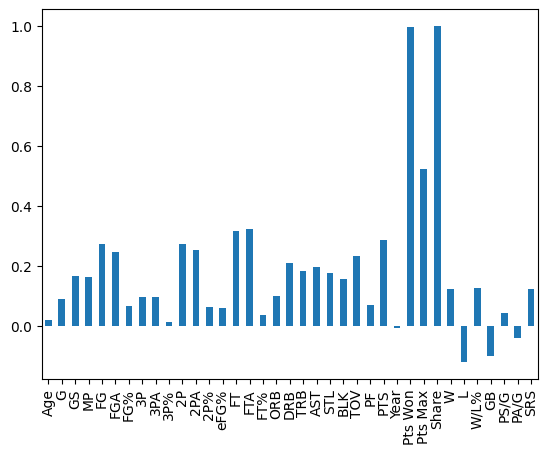

In [14]:
import pandas as pd
mvps = pd.read_csv("mvps.csv")
# Select relevant columns
mvps = mvps[["Player", "Year", "Pts Won", "Pts Max", "Share"]]
mvps

players = pd.read_csv("players.csv")
players
# Remove unneeded columns
del players["Rk"]
del players["Unnamed: 0"]

players["Player"].head(50)

# Remove HOF asterisk from player names
players["Player"] = players["Player"].str.replace("*", "", regex=False)

# players.groupby(["Player", "Year"])

def single_row(df):
  # If only one instance of player in a season return
  if df.shape[0]==1:
    return df
  # Otherwise take the total stats for the season and assignment the most recently played team in that season and return
  else:
    row = df[df["Tm"] == "TOT"]
    row["Tm"] = df.iloc[-1,:]["Tm"]
    return row

players = players.groupby(["Player", "Year"]).apply(single_row)

players.head(20)

players.index = players.index.droplevel()
players.index = players.index.droplevel()

players[players["Player"] == "Greg Anderson"]

# Combining tables
combined = players.merge(mvps, how="outer", on=["Player", "Year"])

combined[combined["Pts Won"]>0]

combined[["Pts Won", "Pts Max", "Share"]] = combined[["Pts Won", "Pts Max", "Share"]].fillna(0)




teams = pd.read_csv("teams.csv")
# Remove divsion dividing rows
teams = teams[~teams["W"].str.contains("Division")]

# Remove asterisk indicating championship winning teams in that season
teams["Team"] = teams["Team"].str.replace("*", "", regex=False)


teams.head(30)

# Get dictionary of team name and nickname and map them in combined table
nicknames = {}
with open("nicknames.csv") as f:
  lines = f.readlines()

  for line in lines[1:]:
    abbrev,name = line.replace("\n", "").split(",")
    nicknames[abbrev]= name

nicknames

combined["Team"] = combined["Tm"].map(nicknames)
combined.head(5)

# Combine teams and combined table
stats = combined.merge(teams, how="outer", on=["Team", "Year"])

#Fix dtypes of columns in new stats table
del stats["Unnamed: 0"]
stats = stats.apply(pd.to_numeric, errors="ignore")
stats.dtypes
stats["GB"].unique()
stats["GB"] = stats["GB"].str.replace("—", "0")
stats["GB"] = pd.to_numeric(stats["GB"])

stats.to_csv("player_mvp_stats.csv")


# Test functions
highest_scoring = stats[stats["G"] > 70].sort_values("PTS", ascending=False).head(20)
highest_scoring.plot.bar("Player", "PTS")
stats.groupby("Year").apply(lambda x: x.sort_values("PTS", ascending=False).head(1))
highest_scoring.plot.bar("Year", "PTS")

# Convert object columns to numeric where applicable
for col in stats.columns:
    if stats[col].dtype == 'object':
        try:
            stats[col] = pd.to_numeric(stats[col])
        except ValueError:
            pass  # Skip columns that cannot be converted

# Find correlations in columns based on Share column
stats.corr(numeric_only=True)["Share"]
stats.corr(numeric_only=True)["Share"].plot.bar()
